## XGBoost

In [135]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, r2_score, cohen_kappa_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
import shap
from statistics import mode
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

### Regression Problems

In [2]:
trn = pd.read_csv("../data/trn.reg.csv.gz", compression='gzip', low_memory=False)
tst = pd.read_csv("../data/tst.reg.csv.gz", compression='gzip', low_memory=False)

trn_X = trn.drop(["SMILES", "ref", "set", "name", "LogS"], axis=1)
tst_X = tst.drop(["SMILES", "set", "name", "LogS"], axis=1)
trn_y = trn["LogS"]
tst_y = tst["LogS"]

Hyper-parameter Tuning.

In [48]:
tune_space = {
    "eta": hp.choice("eta", [0.01, 0.1, 0.3]),
    "gamma": hp.uniform("gamma", 1, 9),
    "alpha": hp.quniform("alpha", 40, 180, 1),
    "lambda": hp.uniform("lambda", 0, 1),
    "max_depth": hp.randint("max_depth", 6, 10),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),

    "objective": "reg:squarederror",

    "booster": "gbtree",  # ["gbtree", "gblinear", "dart"]
    "eval_metric": "rmse",
    "tree_method": "auto",  # ["auto", "hist", "exact", "approx"]

    "num_boost_round": hp.choice("num_boost_round", [100, 200, 300]),
    "nfold": 5
}

In [13]:
def tune_obj(space):
    eval_history = xgb.cv(
        params={
            "eta": space["eta"],
            "gamma": space["gamma"],
            "alpha": space["alpha"],
            "lambda": space["lambda"],
            "max_depth": space["max_depth"],
            "min_child_weight": space["min_child_weight"],
            "colsample_bytree": space["colsample_bytree"],

            "objective": space["objective"],
            "booster": space["booster"],
            "eval_metric": space["eval_metric"],
            "tree_method": space["tree_method"]
        },
        dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
        num_boost_round=space["num_boost_round"],
        metrics=space["eval_metric"],
        nfold=space["nfold"]
    )
    return {
        "loss": min(eval_history["test-rmse-mean"]),
        'status': STATUS_OK
    }

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

In [ ]:
best_params

In [3]:
best_params = {
    "eta": 0.1,
    "gamma": 1.0137931490200134,
    "alpha": 40.0,
    "lambda": 0.3650826004579582,
    "max_depth": 6,
    "min_child_weight": 0,
    "colsample_bytree": 0.7217948417944005,

    "objective": "reg:squarederror",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",

    "num_boost_round": 100,
    "early_stopping_rounds": 10,
    "nfold": 5
}

K-fold CV.

In [18]:
def k_fold_CV(n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    rmse, r2 = [], []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]
        booster = xgb.XGBRegressor(
            n_estimators=best_params["num_boost_round"],
            max_depth=best_params["max_depth"],
            learning_rate=best_params["eta"],
            objective="reg:squarederror",
            booster=best_params["booster"],
            tree_method=best_params["tree_method"],
            gamma=best_params["gamma"],
            min_child_weight=best_params["min_child_weight"],
            colsample_bytree=best_params["colsample_bytree"],
            reg_alpha=best_params["alpha"],
            reg_lambda=best_params["lambda"],
            eval_metric=best_params["eval_metric"]
        )
        booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=0)

        pred_val = booster.predict(vX)
        rmse.append(root_mean_squared_error(vy, pred_val))
        r2.append(r2_score(vy, pred_val))

    return pd.DataFrame({"rmse": rmse, "r2": r2})

In [ ]:
pd.concat([k_fold_CV() for _ in range(10)])

Prediction and estimation.

In [13]:
def predict():
    kf = KFold(n_splits=5, shuffle=True)
    prediction = []
    boosters = []
    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]
        booster = xgb.XGBRegressor(
            n_estimators=best_params["num_boost_round"],
            max_depth=best_params["max_depth"],
            # learning_rate=best_params["eta"],
            objective="reg:squarederror",
            # booster=best_params["booster"],
            # tree_method=best_params["tree_method"],
            # gamma=best_params["gamma"],
            # min_child_weight=best_params["min_child_weight"],
            # colsample_bytree=best_params["colsample_bytree"],
            # reg_alpha=best_params["alpha"],
            # reg_lambda=best_params["lambda"],
            # eval_metric=best_params["eval_metric"],
            # early_stopping_rounds=20
        )
        booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=0)
        prediction.append(booster.predict(tst_X))
        boosters.append(booster)

    return np.mean(prediction, axis=0), boosters

In [14]:
preds, boosters = zip(*[predict() for _ in range(50)])
preds = pd.concat([pd.Series(p) for p in preds], axis=1)

In [15]:
rmse, r2 = defaultdict(list), defaultdict(list)

for pred in [preds[c] for c in preds.columns]:
    df = pd.DataFrame({"pred": pred, "set": tst["set"], "true": tst["LogS"]})
    for s in df["set"].unique():
        p = df[df["set"] == s]
        rmse[s].append(root_mean_squared_error(p["true"], p["pred"]))
        r2[s].append(r2_score(p["true"], p["pred"]))

In [16]:
for s in rmse.keys():
    print(f"[{s}] rmse:{np.mean(rmse[s]):.2f}±{np.std(rmse[s]):.2f} r2:{np.mean(r2[s]):.2f}±{np.std(r2[s]):.2f}")

[2008SC Test Set] rmse:1.03±0.01 r2:0.43±0.01
[2019SC Testset 1] rmse:0.84±0.01 r2:0.41±0.02
[2019SC Testset 2] rmse:1.60±0.05 r2:0.36±0.04


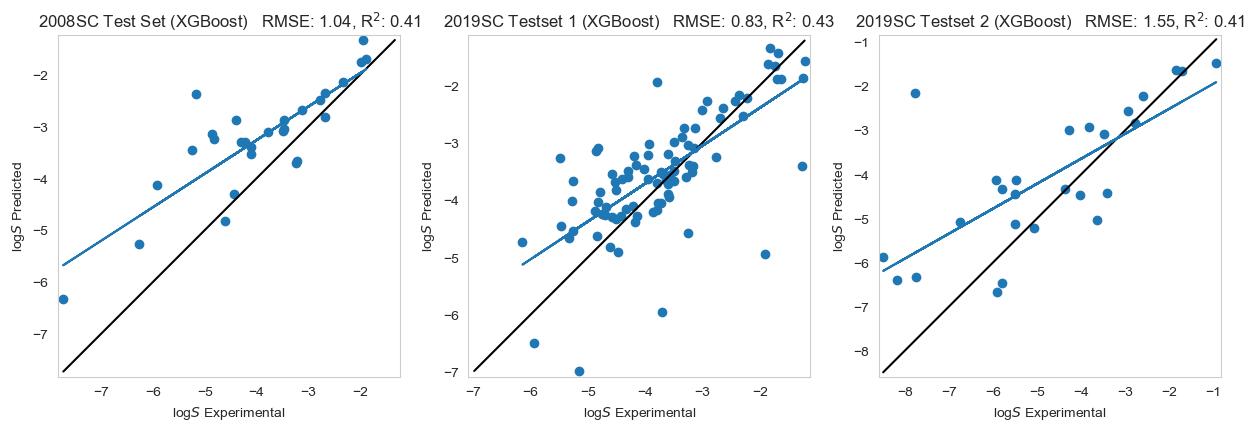

In [17]:
def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "XGBoost"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))
df = pd.DataFrame({"pred": preds.iloc[:, np.argmin(np.array(list(rmse.values())).mean(axis=0))],
                   "set": tst["set"], "true": tst["LogS"]})
for s, ax in zip(rmse.keys(), axs):
    idx = tst[tst["set"] == s].index
    t = df["true"].loc[idx]
    p = df["pred"].loc[idx]
    subplot(t, p, ax)
    ax.grid(False)
    ax.set_title(f"{s} ({model_name})   "
                 f"RMSE: {root_mean_squared_error(t, p):.2f}, "
                 f"R$^2$: {r2_score(t, p):.2f}")

Permutation Feature Importance

In [21]:
pi = [
    permutation_importance(booster, tst_X, tst_y, n_jobs=-1)
    for booster in list(np.concatenate(boosters))
]

In [ ]:
perm_importance = pd.concat([pd.DataFrame(pi[i].importances_mean) for i in range(len(pi))], axis=1)
perm_importance.index = trn_X.columns
perm_importance_mean = perm_importance.mean(axis=1)
min_v, max_v = perm_importance.min().min(), perm_importance.max().max()
perm_importance_sort = ((perm_importance - min_v) / (max_v - min_v)).loc[
    perm_importance_mean.sort_values(ascending=False).index]
perm_importance_sort

SHAP feature importance. (Tree Explainer)

In [31]:
si = [
    shap.TreeExplainer(booster).shap_values(tst_X, tst_y)
    for booster in list(np.concatenate(boosters))
]

In [ ]:
shap_importance = pd.concat([pd.Series(np.abs(s).mean(0)) for s in si], axis=1)
shap_importance.index = trn_X.columns
shap_importance_mean = shap_importance.mean(axis=1)
min_v, max_v = shap_importance.min().min(), shap_importance.max().max()
shap_importance_sort = ((shap_importance_mean - min_v) / (max_v - min_v)).loc[
    shap_importance_mean.sort_values(ascending=False).index]
shap_importance_sort

## Classification Problem

In [125]:
trn = pd.concat([pd.read_csv(f"../data/trn.EUOS-SLAS.Part{i}.csv.gz") for i in range(1, 9)])
tst = pd.concat([pd.read_csv(f"../data/tst.EUOS-SLAS.Part{i}.csv.gz") for i in range(1, 5)])

trn_X = trn.drop(["SMILES", "SMILES.1", "solubility", "Id"], axis=1)
tst_X = tst.drop(["SMILES", "SMILES.1", "Id"], axis=1)
trn_y = trn["solubility"]

In [107]:
tune_space = {
    "eta": hp.choice("eta", [0.01, 0.1, 0.3]),
    "gamma": hp.uniform("gamma", 1, 9),
    "alpha": hp.quniform("alpha", 40, 180, 1),
    "lambda": hp.uniform("lambda", 0, 1),
    "max_depth": hp.randint("max_depth", 6, 10),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),

    "objective": "multi:softmax",

    "booster": "gbtree",  # ["gbtree", "gblinear", "dart"]
    "eval_metric": "mlogloss",
    "tree_method": "auto",  # ["auto", "hist", "exact", "approx"]

    "num_boost_round": hp.choice("num_boost_round", [100, 200, 300]),
    "nfold": 5
}

In [112]:
def tune_obj(space):
    eval_history = xgb.cv(
        params={
            "eta": space["eta"],
            "gamma": space["gamma"],
            "alpha": space["alpha"],
            "lambda": space["lambda"],
            "max_depth": space["max_depth"],
            "min_child_weight": space["min_child_weight"],
            "colsample_bytree": space["colsample_bytree"],

            "objective": space["objective"],
            'num_class': 3,
            "booster": space["booster"],
            "eval_metric": space["eval_metric"],
            "tree_method": space["tree_method"]
        },
        dtrain=xgb.DMatrix(data=trn_X, label=trn_y),
        num_boost_round=space["num_boost_round"],
        metrics=space["eval_metric"],
        nfold=space["nfold"]
    )
    return {
        "loss": min(eval_history["test-mlogloss-mean"]),
        'status': STATUS_OK
    }

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

In [120]:
best_params = {
    "eta": 0.1,
    "gamma": 1.0137931490200134,
    "alpha": 40.0,
    "lambda": 0.3650826004579582,
    "max_depth": 6,
    "min_child_weight": 0,
    "colsample_bytree": 0.7217948417944005,

    "objective": "multi:softmax",
    "booster": "gbtree",
    "eval_metric": "mlogloss",
    "tree_method": "auto",

    "num_boost_round": 100,
    "early_stopping_rounds": 10,
    "nfold": 5
}

K-fold CV.

In [126]:
def k_fold_CV(n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    qck = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]
        booster = xgb.XGBClassifier(
            num_class=3,
            # n_estimators=best_params["num_boost_round"],
            # max_depth=best_params["max_depth"],
            # learning_rate=best_params["eta"],
            objective="multi:softmax",
            # gamma=best_params["gamma"],
            # min_child_weight=best_params["min_child_weight"],
            # colsample_bytree=best_params["colsample_bytree"],
            # reg_alpha=best_params["alpha"],
            # reg_lambda=best_params["lambda"],
            eval_metric=best_params["eval_metric"]
        )
        booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=0)

        pred_val = booster.predict(vX)
        qck.append(cohen_kappa_score(vy, pred_val, weights="quadratic"))

    return pd.DataFrame({"QCK": qck})

In [ ]:
pd.concat([k_fold_CV() for _ in range(10)])

Prediction and estimation.

In [136]:
def predict():
    kf = KFold(n_splits=5, shuffle=True)
    prediction = []
    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X.loc[trn_idx], trn_X.loc[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]
        booster = xgb.XGBClassifier(
            num_class=3,
            # n_estimators=best_params["num_boost_round"],
            # max_depth=best_params["max_depth"],
            # learning_rate=best_params["eta"],
            objective="multi:softmax",
            # gamma=best_params["gamma"],
            # min_child_weight=best_params["min_child_weight"],
            # colsample_bytree=best_params["colsample_bytree"],
            # reg_alpha=best_params["alpha"],
            # reg_lambda=best_params["lambda"],
            eval_metric=best_params["eval_metric"]
        )
        booster.fit(tX, ty, eval_set=[(vX, vy)], verbose=0)
        prediction.append(booster.predict(tst_X))

    return np.array([mode(p) for p in list(zip(*prediction))])

In [ ]:
preds = [predict() for _ in range(50)]
preds = pd.DataFrame([p for p in preds]).transpose()
preds

Upload the predictions to the challenge to get feedback on the model's performance.